In [1]:
import torch
from torch import nn
from torchvision.transforms import Compose
from torch.utils.data import Dataset,DataLoader
from torch.optim import SGD


from sklearn.datasets import load_iris

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class IrisData(Dataset):
    def __init__(self,transforms = None):
        X,y = load_iris(return_X_y=True)
        
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
        self.len = X.shape[0]
        
        self.transforms = transforms
        
        self.mu = self.X.mean(0)
        self.std = self.X.std(0)
        
    def __getitem__(self,index):
        sample = self.X[index],self.y[index]
        
        if self.transforms:
            sample = self.transforms(sample)
            
        return sample
    
    def __len__(self):
        return self.len 

In [3]:
class Standard_Normalization(object):
    def __init__(self,mu,std):
        self.mu = mu
        self.std = std
        
    def __call__(self,sample):
        x = sample[0]
        y = sample[1]
        
        x = (x-self.mu)/self.std
        
        return x,y

In [4]:
class DNN(nn.Module):
    def __init__(self,layers):
        super(DNN,self).__init__()
        self.hidden = nn.ModuleList()
        
        for input_size,output_size in zip(layers,layers[1:]):
            self.hidden.append(nn.Linear(input_size,output_size))
            
    def forward(self,x):
        n_layers = len(self.hidden)
        for l,layer in zip(range(n_layers),self.hidden):
            x = layer(x)
            
            if l < n_layers-1:
                x = torch.relu(x)
                
        return x

In [5]:
dataset = IrisData()
transforms = Standard_Normalization(dataset.mu,dataset.std)
dataset.transforms = transforms

batch_size = len(dataset)

dataloader = DataLoader(dataset,batch_size = batch_size)

In [6]:
Layers =[4,10,20,20,20,10,5,3]
model = DNN(Layers)

In [7]:
model.parameters

<bound method Module.parameters of DNN(
  (hidden): ModuleList(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=5, bias=True)
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)>

In [8]:
criterion = nn.CrossEntropyLoss()

lr=0.05
optimizer = SGD(model.parameters(),lr=lr)

In [9]:
num_epochs = 5000
print_every = 100
LOSS = []
for epoch in range(num_epochs):
    total_loss = 0
    for x,y in dataloader:
        output = model(x)
        
        loss = criterion(output,y)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.detach().item()*x.shape[0]
        
    LOSS.append(total_loss/len(dataset))
    if (epoch+1) % print_every == 0 or epoch==0:
        print("Epoch {}: loss={}".format(epoch+1,total_loss/len(dataset)))

Epoch 1: loss=1.1714571714401245
Epoch 100: loss=1.0918309688568115
Epoch 200: loss=0.9645723700523376
Epoch 300: loss=0.501221776008606
Epoch 400: loss=0.28350111842155457
Epoch 500: loss=0.17259232699871063
Epoch 600: loss=0.11355477571487427
Epoch 700: loss=0.0812254250049591
Epoch 800: loss=0.062430739402770996
Epoch 900: loss=0.05178926885128021
Epoch 1000: loss=0.04568152129650116
Epoch 1100: loss=0.0419115386903286
Epoch 1200: loss=0.039467550814151764
Epoch 1300: loss=0.03783140331506729
Epoch 1400: loss=0.03667198866605759
Epoch 1500: loss=0.03582369536161423
Epoch 1600: loss=0.03517792001366615
Epoch 1700: loss=0.03466839715838432
Epoch 1800: loss=0.03425594046711922
Epoch 1900: loss=0.03392547741532326
Epoch 2000: loss=0.033662762492895126
Epoch 2100: loss=0.03344321995973587
Epoch 2200: loss=0.03324342146515846
Epoch 2300: loss=0.03307556360960007
Epoch 2400: loss=0.032931651920080185
Epoch 2500: loss=0.032788679003715515
Epoch 2600: loss=0.03265215829014778
Epoch 2700: los

In [10]:
with torch.no_grad():
    y_pred = model(dataset[:][0]).argmax(1)
    print((y_pred==dataset.y).type(torch.FloatTensor).mean())

tensor(0.9933)


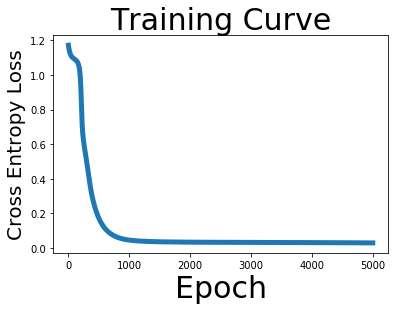

In [15]:
plt.plot(list(range(num_epochs)),LOSS,linewidth=5)
plt.xlabel("Epoch",fontsize=30)
plt.title("Training Curve",fontsize=30)
plt.ylabel("Cross Entropy Loss",fontsize=20)
plt.show()